In [1]:
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import MessagePassing
from torch_geometric.nn.aggr import SumAggregation
import torch
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, "..")
from classes.pca import PCA
from classes.kmeans import KMeans

In [2]:
def elements_for_random_graph(num_nodes):
    cutoff = 2.5

    box_size=10
    positions = []
    for i in range(num_nodes):
        new_position = torch.rand(1, 2) * box_size
        if len(positions) > 0:
            all_positions = torch.vstack(positions)
            while torch.any(torch.cdist(all_positions, new_position) < 0.75*cutoff) or \
            torch.all(torch.cdist(all_positions, new_position) > cutoff):
                new_position = torch.rand(1, 2) * box_size        
        positions.append(new_position)

    positions = torch.vstack(positions)

    edge_index = []
    for i in range(len(positions)):
        for j in range(len(positions)):
            edge_index.append([i, j])

    edge_index = torch.tensor(np.array(edge_index).T, dtype=torch.int64).reshape(2, -1)
    x = torch.tensor(list(range(num_nodes)),dtype=torch.float32)
    return edge_index, positions, x #Returns the edge connections, positions of each node, and then the value of each node

In [3]:
#torch.manual_seed(0)
graphs = []
positions_tot = []
for i in range(2):
    edge_index, positions, x_tensor = elements_for_random_graph(4)
    positions_tot.append(positions)
    graphs.append(Data(x=x_tensor, edge_index=edge_index, pos=positions))

def plot(ax, graph, color="C0", **plot_kwargs):
    with torch.no_grad():
        positions = graph.pos
        edge_indices = graph.edge_index
        cons1 = positions[edge_indices[0]]
        cons2 = positions[edge_indices[1]]
        ax.set_xlim([torch.min(cons1[:,0])-0.5, torch.max(cons1[:,0])+0.5])
        ax.set_ylim([torch.min(cons1[:,1])-0.5, torch.max(cons1[:,1])+0.5])

        for con1, con2 in zip(cons1, cons2):
            ax.plot([con1[0], con2[0]], [con1[1], con2[1]], c="k")
    
        for i, position in enumerate(positions):
            ax.plot(position[0], position[1], "o", markeredgecolor="k", color=color, ms=30, **plot_kwargs)
            ax.annotate(text=f"{i}", xy=(position), ha='center', va="center", color="white", fontsize=12)

def get_adj_matrix(graph):
    adj_matrix = to_dense_adj(edge_index=graph.edge_index)
    eigvals, eigmat = torch.linalg.eig(adj_matrix)
    real_eigs = torch.real(eigvals)
    real_eigs, indices = torch.sort(real_eigs, descending=True)
    return adj_matrix, real_eigs[0]

Text(0.5, 0, 'Ordered eigenvalue entries')

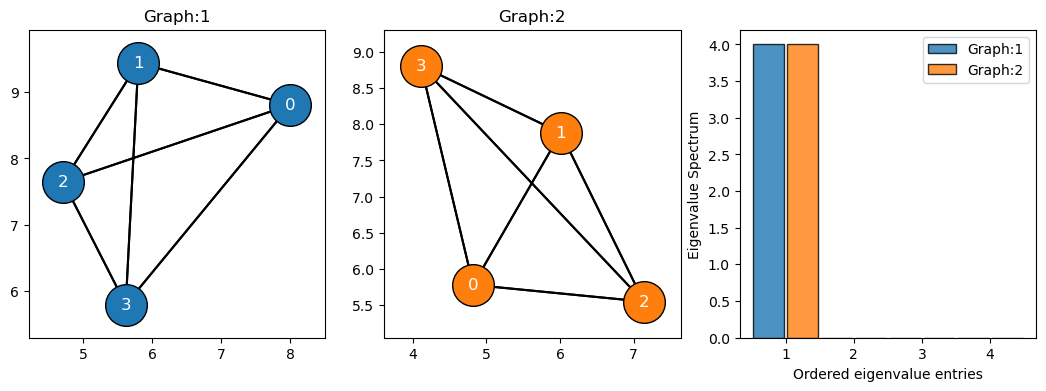

In [4]:
fig, axs = plt.subplots(1,3, figsize=(13,4))
eigvals_tot = []
for i, ax, graph, color in zip(range(len(graphs)), axs, graphs, ["C0", "C1"]):
    ax.set_title(f"Graph:{i+1}")
    plot(ax=ax, graph=graph, color=color)
    mat, eigvals = get_adj_matrix(graph=graph)
    eigvals_tot.append(eigvals)

bin_width = 0.8
step_size = bin_width*len(eigvals_tot)

with torch.no_grad():
    for j, eigvals in enumerate(eigvals_tot):
        plot_xs = [i*step_size+j*bin_width for i in range(len(eigvals))]
        axs[2].bar(plot_xs, eigvals, width=bin_width*0.90, alpha=0.8, edgecolor="k", label=f"Graph:{j+1}")
    x_ticks = torch.tensor(plot_xs)-bin_width/2.0
    axs[2].set_xticks(x_ticks, ["1","2","3","4"])

axs[2].legend()
axs[2].set_ylabel("Eigenvalue Spectrum")
axs[2].set_xlabel("Ordered eigenvalue entries")

In [5]:
def keep_short_edges(edge_index, positions, r_cut=2.5):
    edge_index_to_keep = []
    for edge in edge_index.T:
        source = positions[edge[0]]
        target = positions[edge[1]]
        if torch.linalg.norm(source-target) <= r_cut:
            edge_index_to_keep.append(edge.numpy())
    #print(edge_index_to_keep)
    return torch.tensor(edge_index_to_keep).T

def random_graph(num_nodes, r_cut=2.5):
    edge_index, positions, x_tensor = elements_for_random_graph(num_nodes=num_nodes)
    edge_index = keep_short_edges(edge_index, positions, r_cut=r_cut)
    graph = Data(x_tensor, edge_index=edge_index, pos=positions)
    return graph

C:\Users\karst\AppData\Local\Temp\ipykernel_47480\3037576272.py:9: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\b\abs_6fueooay2f\croot\pytorch-select_1707342446212\work\torch\csrc\utils\tensor_new.cpp:278.)
  return torch.tensor(edge_index_to_keep).T


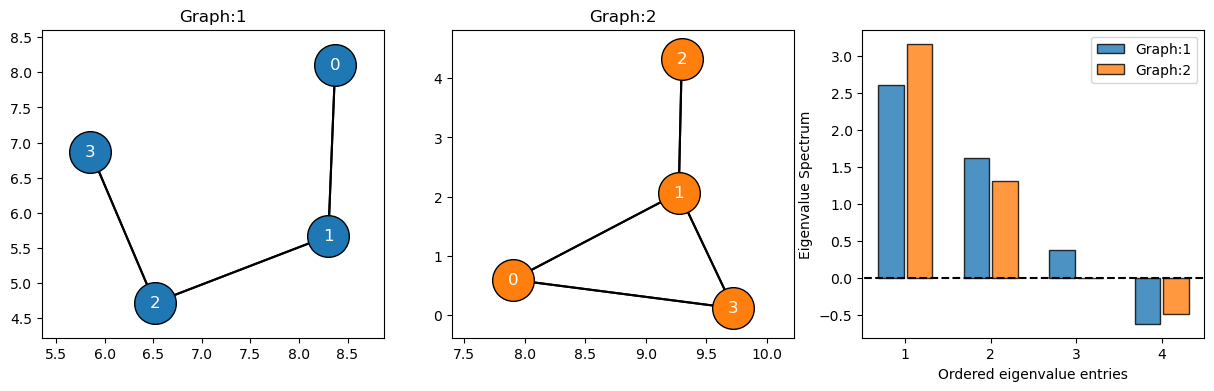

In [6]:
graphs = []
for i in range(2):
    graphs.append(random_graph(4))

fig, axs = plt.subplots(1,3, figsize=(15,4))
eigvals_tot = []
for i, ax, graph, color in zip(range(len(graphs)), axs, graphs, ["C0", "C1"]):
    ax.set_title(f"Graph:{i+1}")
    plot(ax=ax, graph=graph, color=color)
    mat, eigvals = get_adj_matrix(graph=graph)
    eigvals_tot.append(eigvals)

bin_width = 0.8
step_size = (bin_width+0.4)*len(eigvals_tot)

with torch.no_grad():
    for j, eigvals in enumerate(eigvals_tot):
        plot_xs = [i*step_size+j*bin_width for i in range(len(eigvals))]
        axs[2].bar(plot_xs, eigvals, width=bin_width*0.90, alpha=0.8, edgecolor="k", label=f"Graph:{j+1}")
    x_ticks = torch.tensor(plot_xs)-bin_width/2.0
    axs[2].set_xticks(x_ticks, ["1","2","3","4"])
    axs[2].hlines(-0.0, -2.0, 10.0, linestyles="--", colors="k")
    axs[2].set_xlim([-bin_width, torch.max(x_ticks)+1.5*bin_width])

axs[2].set_ylabel("Eigenvalue Spectrum")
axs[2].set_xlabel("Ordered eigenvalue entries")
s = axs[2].legend()


In [7]:
#Next assignment can be troublesome, luckily we have learnt machine learning
N = 7000
eigvals_tot = []
graphs = []
for i in range(N):
    graph = random_graph(5)
    graphs.append(graph)
    mat, eigvals = get_adj_matrix(graph=graph)
    eigvals_tot.append(eigvals.numpy())

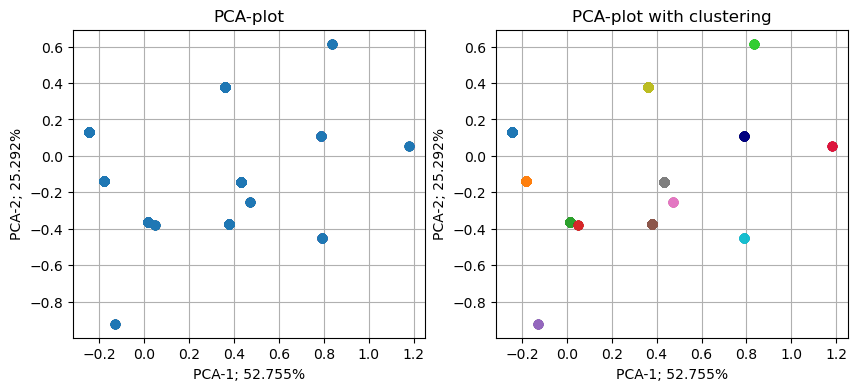

In [17]:
fig, axs = plt.subplots(1,2, figsize=(10,4))
eigvals_tot = np.array(eigvals_tot)

pca = PCA(2)
pca.fit(eigvals_tot)
p_transformed = pca.transform(eigvals_tot)
axs[0].plot(p_transformed[:,0], p_transformed[:,1], 'o', alpha=0.2)

exp_vars = pca.explained_var

for ax in axs:
    ax.grid()
    ax.set_xlabel(f"PCA-1; {round(exp_vars[0]*100,3)}%") #Need to add how much variance they account for here.
    ax.set_ylabel(f"PCA-2; {round(exp_vars[1]*100,3)}%")

axs[0].set_title(f"PCA-plot")
axs[1].set_title("PCA-plot with clustering")
init_mus = np.array([[-0.2,0.2],
                     [-0.2, -0.2],
                     [-0.02, -0.25],
                     [0.0, -0.5],
                     [-0.2, -1.0],
                     [0.4, -0.4],
                     [0.5, -0.3],
                     [0.4, -0.1],
                     [0.4, 0.3],
                     [0.8, -0.4],
                     [0.8, 0.0],
                     [0.8, 0.5],
                     [1.2, 0.0]])

#axs[0].plot(init_mus[:,0], init_mus[:,1], "o")

kmeans = KMeans(n_clusters=13, max_iter=5000)
kmeans.fit(p_transformed, init_mus=init_mus)#np.random.randn(14, 2))#init_mus)
labels = kmeans.predict(p_transformed)
extra_cols = ["navy", "olive", "crimson", "limegreen"]

for i in range(13):
    indices = np.argwhere(labels == i)
    plot_points = p_transformed[indices].squeeze(1)
    if i > 9:
        axs[1].plot(plot_points[:,0], plot_points[:,1], 'o', color=extra_cols[10-i], alpha=0.2)
    else:
        axs[1].plot(plot_points[:,0], plot_points[:,1], 'o', color=f"C{i}", alpha=0.2)

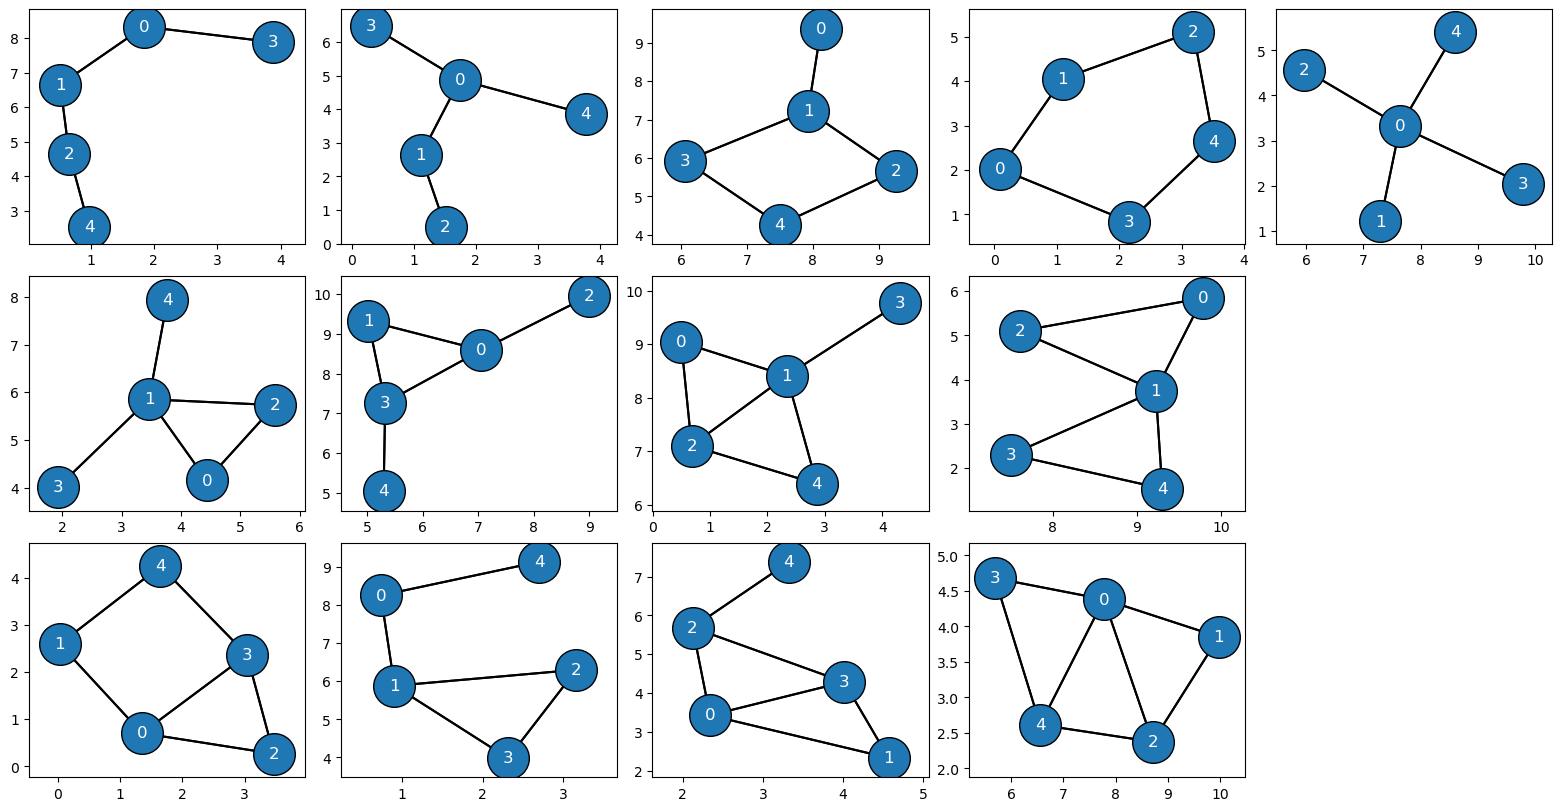

In [21]:
fig = plt.figure(figsize=(15.5,8), layout="constrained")
axs = []
for i in range(5):
    axs.append(fig.add_subplot(3,5,i+1))
for i in range(4):
    axs.append(fig.add_subplot(3,5,i+6))
    axs.append(fig.add_subplot(3,5,i+11))

for i, ax in enumerate(axs):
    indices = np.argwhere(labels == i)
    graph = graphs[indices[0][0]]
    plot(ax=ax, graph=graph)